In [1]:
from typing import Any
import numpy as np
import pandas as pd
from lisatools.diagnostic import snr as snr_func
from lisatools.diagnostic import plot_covariance_contour, plot_covariance_corner
from lisatools.sensitivity import get_sensitivity, A1TDISens
from lisatools.detector import mrdv1, scirdv1, Orbits, DefaultOrbits, LISAModel, EqualArmlengthOrbits
from lisatools.utils.constants import *
from lisatools.sources import BBHCalculationController, GBCalculationController, EMRICalculationController
from lisatools.sources.emri import EMRITDIWaveform
from lisatools.sources.bbh import BBHSNRWaveform
from lisatools.sources.gb import GBAETWaveform
from lisatools.stochastic import StochasticContribution, StochasticContributionContainer

from gen_gb_pe_dist import run_posterior_estimate_vgbs
import os
from abc import ABC
from typing import Union, Tuple
import matplotlib.pyplot as plt
from scipy import interpolate

%matplotlib inline

No CuPy
No CuPy or GPU PhenomHM module.
No CuPy or GPU interpolation available.
No CuPy or GPU response available.


## Define Stochastic Contributions

In [2]:
# Define a frequency axis
f = np.logspace(-4, 0, 1000)

In [3]:
def get_df(Tobs: float, dt: float) -> float:
    Nobs = int(Tobs / dt)
    Tobs = Nobs * dt
    df = 1 / Tobs
    return df


### With and without stochastic contribution

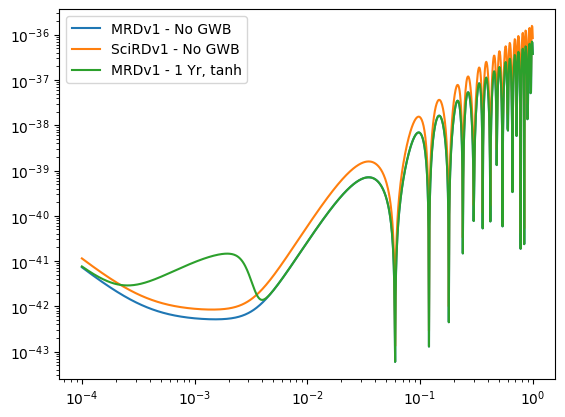

In [4]:
fn = f.copy()
Sn_no_GWB_mrd = get_sensitivity(fn, model=mrdv1, sens_fn=A1TDISens)
plt.loglog(fn, Sn_no_GWB_mrd, c=f"C0", label="MRDv1 - No GWB")
Sn_no_GWB_srd = get_sensitivity(fn, model=scirdv1, sens_fn=A1TDISens)
plt.loglog(fn, Sn_no_GWB_srd, c=f"C1", label="SciRDv1 - No GWB")
Sn_with_GWB_1yr = get_sensitivity(fn, model=mrdv1, sens_fn=A1TDISens, stochastic_params=(YRSID_SI,))
plt.loglog(fn, Sn_with_GWB_1yr, c=f"C2", label="MRDv1 - 1 Yr, tanh")
plt.legend()


## Diagnostics

Setup all snr calculators

In [5]:
calculators = {}
orbits_here = EqualArmlengthOrbits()
Tobs = 0.9 * YRSID_SI
dt = 10.0
Nobs = int(Tobs / dt)
Tobs = Nobs * dt

psd_kwargs = dict(
    stochastic_params=(Tobs,),
)

# black hole generator
bbh = BBHSNRWaveform(response_kwargs=dict(TDItag="AET", orbits=orbits_here, tdi2=False))

calculators["bbh"] = BBHCalculationController(
    bbh, 
    scirdv1,
    psd_kwargs, 
    Tobs / YRSID_SI,
    dt,
    psd=A1TDISens
)

# gb generator
gb = GBAETWaveform(orbits=orbits_here)

calculators["gb"] = GBCalculationController(
    gb, 
    scirdv1,
    psd_kwargs, 
    Tobs / YRSID_SI,
    dt,
    psd=A1TDISens
)

# emri generator
emri = EMRITDIWaveform(
    T=Tobs / YRSID_SI, 
    dt=dt, 
    emri_waveform_kwargs=dict(inspiral_kwargs=dict(integrate_backwards=True)),
    response_kwargs=dict(tdi="1st generation", orbits=orbits_here)
)

calculators["emri"] = EMRICalculationController(
    emri, 
    scirdv1,
    psd_kwargs, 
    Tobs / YRSID_SI,
    dt,
    psd=A1TDISens
)
    


### MBHBs

1256.5459351309707


Text(0, 0.5, 'Char strain')

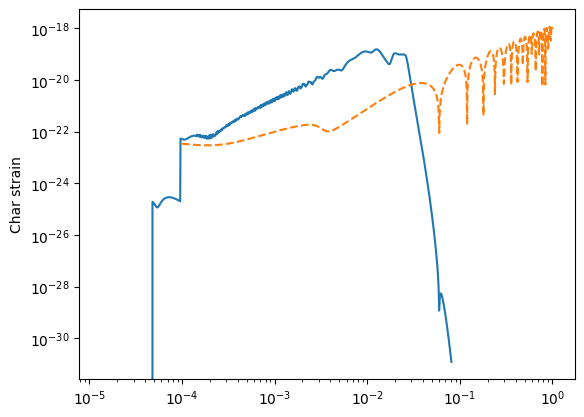

In [6]:
# in SSB

f_ref = 0.0  # let phenom codes set f_ref -> fmax = max(f^2A(f))
phi_ref = 0.5  # phase at f_ref
m1 = 1e6
m2 = 5e5
M = m1 + m2
q = m2 / m1  # m2 less than m1
a1 = 0.2
a2 = 0.4
dist = 10.0 * PC_SI * 1e9  # in m
inc = np.pi / 3.0
beta = np.pi / 4.0  # ecliptic latitude
lam = np.pi / 5.0  # ecliptic longitude
psi = np.pi / 6.0  # polarization angle

t_ref = YRSID_SI * 0.25  # (in the SSB reference frame)

mbh_injection_params = np.array(
    [m1, m2, a1, a2, dist, phi_ref, f_ref, inc, lam, beta, psi, t_ref]
)

print(calculators["bbh"].get_snr(*mbh_injection_params))
Sn = get_sensitivity(fn, model=scirdv1, sens_fn=A1TDISens, **psd_kwargs)
plt.loglog(calculators["bbh"].f_arr, calculators["bbh"].f_arr * np.abs(calculators["bbh"].last_output[0]), c=f"C0")
df = get_df(Tobs, dt)
plt.loglog(fn, np.sqrt(fn) * Sn ** (1/2), c=f"C1", ls="--")
plt.ylabel("Char strain")

In [7]:
# example with last mission
scaled_inj_params, cov = calculators["bbh"].get_cov(
    *mbh_injection_params,
    precision=True,
    more_accurate=False,
    eps=1e-9,
    deriv_inds=None,
)


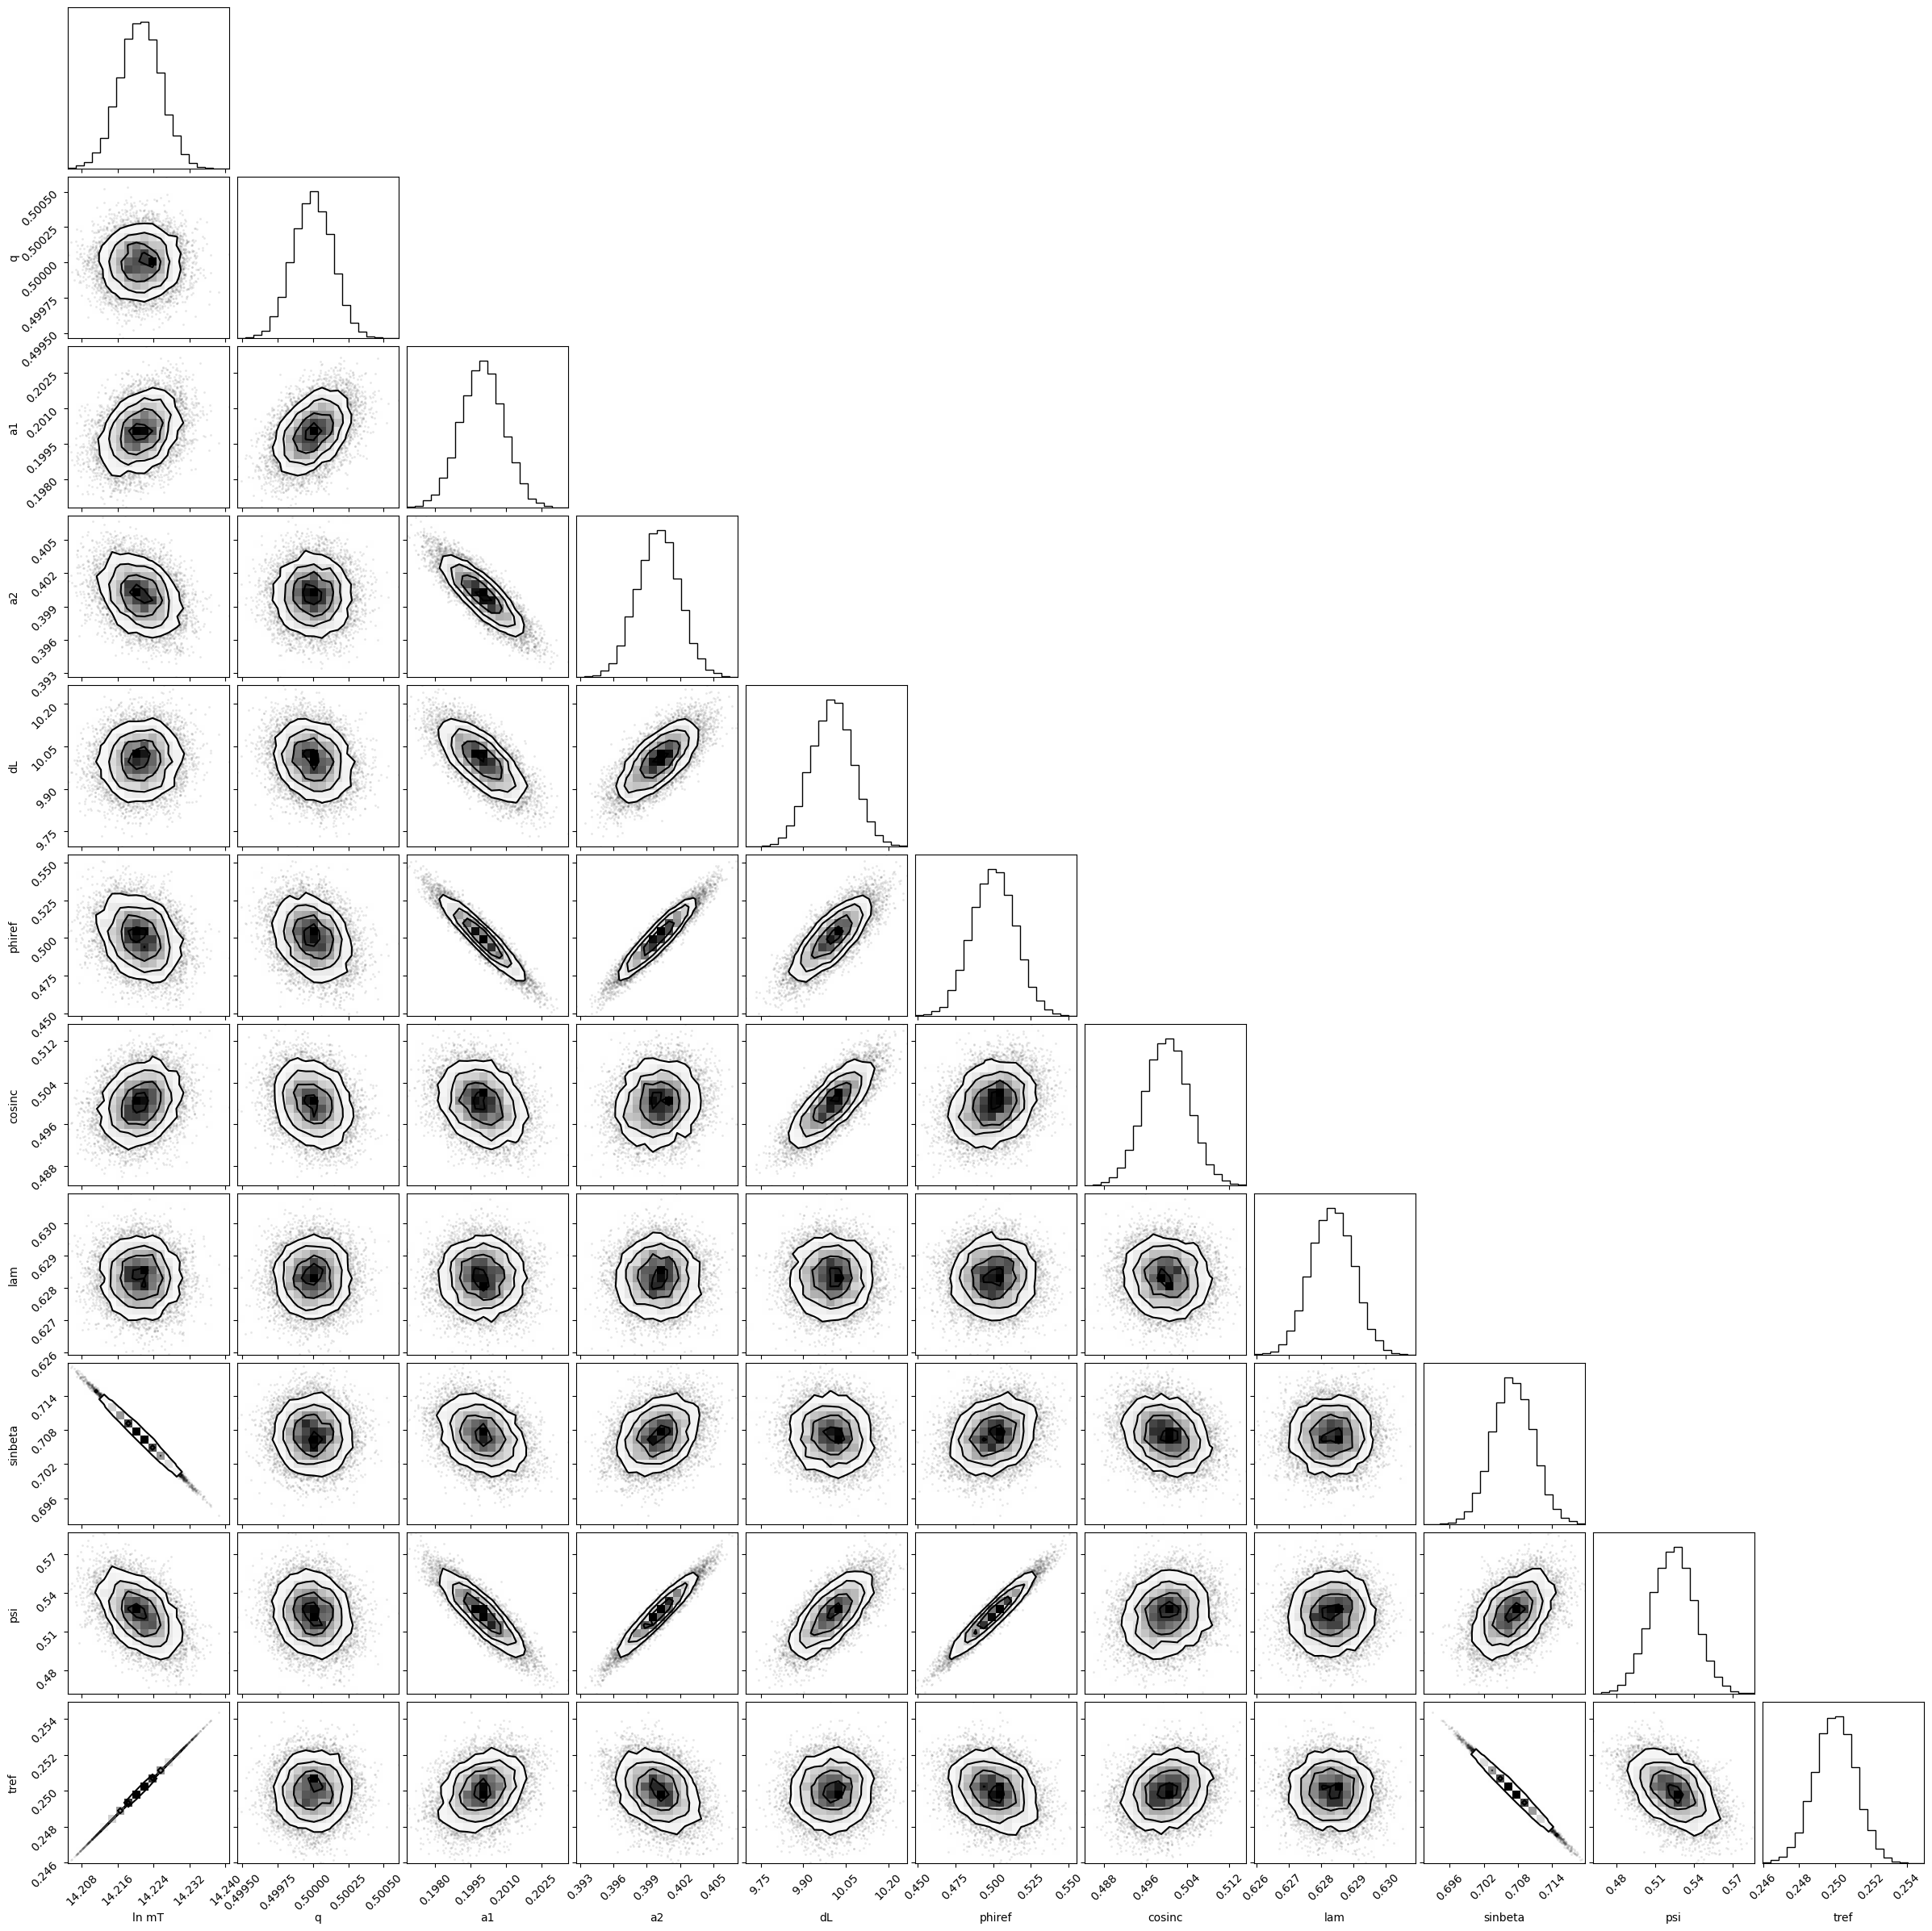

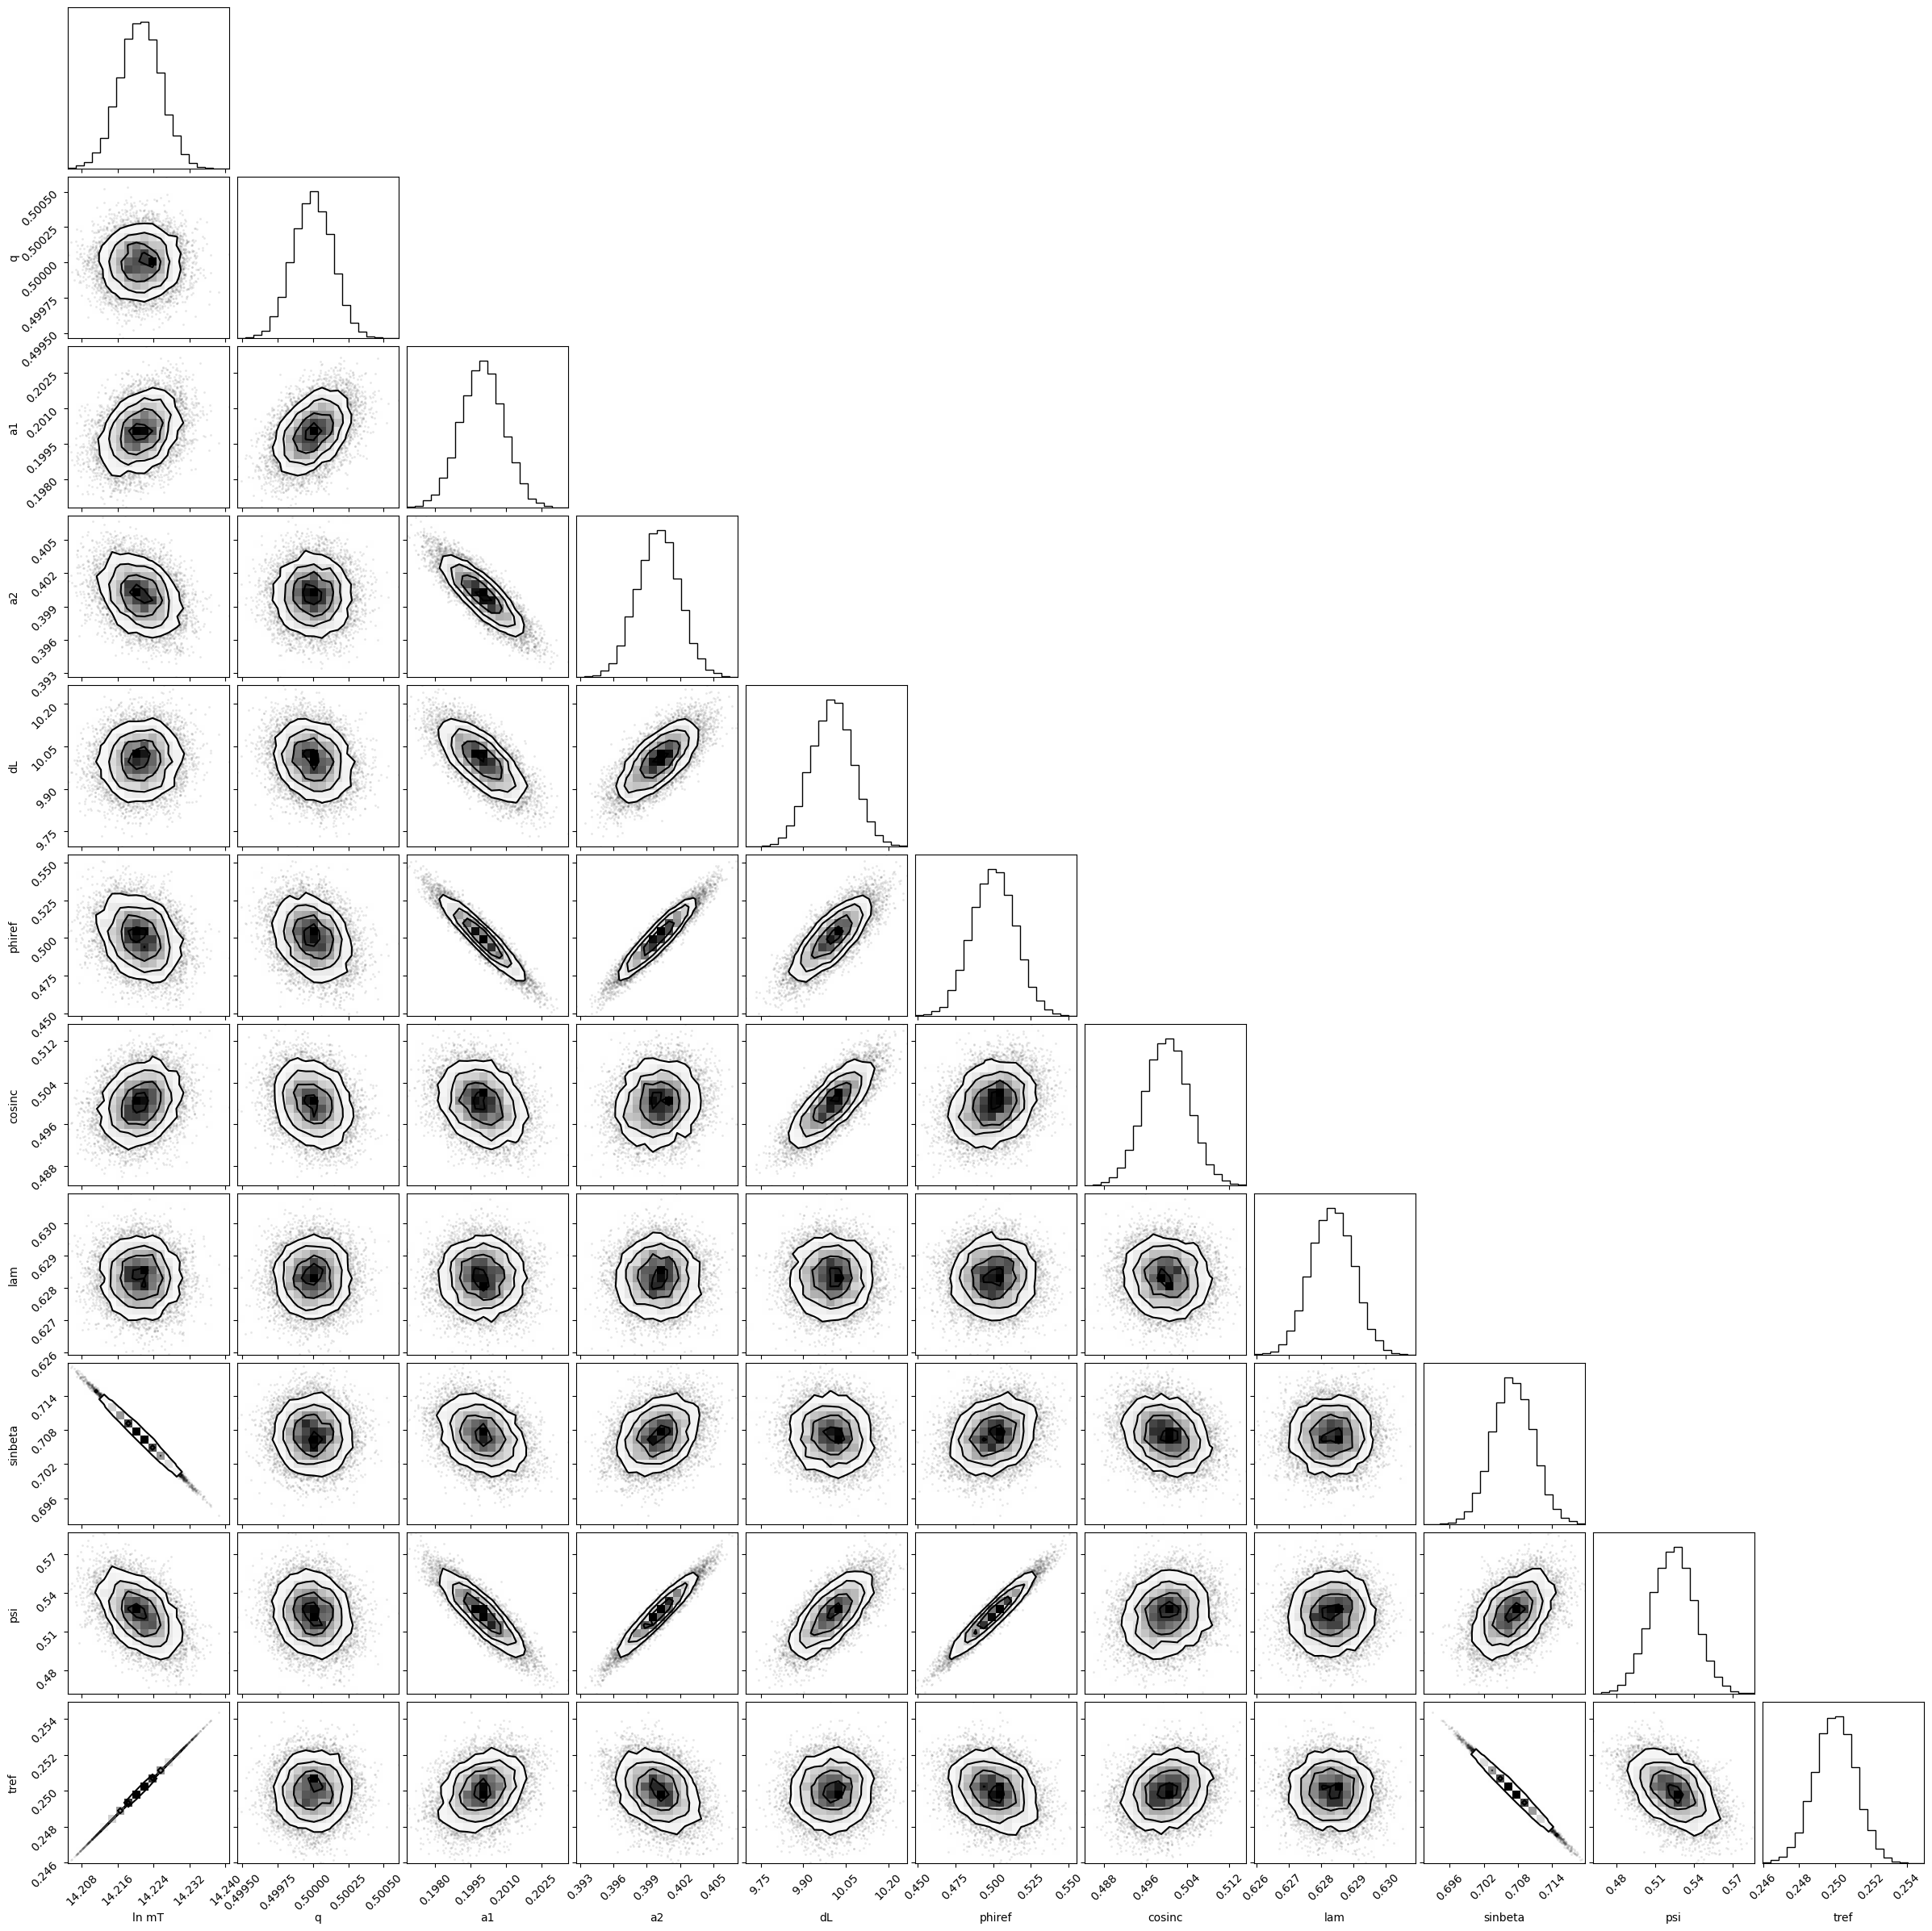

In [8]:
labels=["ln mT", "q", "a1", "a2", "dL", "phiref", "cosinc", "lam", "sinbeta", "psi", "tref"]
plot_covariance_corner(scaled_inj_params, cov, labels=labels, nsamp=10000)

In [9]:

f_ref = 0.0  # let phenom codes set f_ref -> fmax = max(f^2A(f))
phi_ref = 0.5  # phase at f_ref
m1 = 5e6
m2 = 5e6
M = m1 + m2
q = m2 / m1  # m2 less than m1
a1 = 0.2
a2 = 0.4
dist = 10.0 * PC_SI * 1e9  # in m
inc = np.pi / 3.0
beta = np.pi / 4.0  # ecliptic latitude
lam = np.pi / 5.0  # ecliptic longitude
psi = np.pi / 6.0  # polarization angle

t_ref = YRSID_SI * 0.25  # (in the SSB reference frame)

mbh_injection_params = np.array(
    [m1, m2, a1, a2, dist, phi_ref, f_ref, inc, lam, beta, psi, t_ref]
)

from eryn.prior import uniform_dist, ProbDistContainer
from eryn.utils import TransformContainer

 # priors
priors_mbh = ProbDistContainer({
    0: uniform_dist(np.log(1e4), np.log(1e8)),
    1: uniform_dist(0.1, 0.999999999),
    2: uniform_dist(-0.99999999, +0.99999999),
    3: uniform_dist(-0.99999999, +0.99999999),
    4: uniform_dist(0.01, 1000.0),
    5: uniform_dist(0.0, 2 * np.pi),
    6: uniform_dist(-1.0 + 1e-6, 1.0 - 1e-6),
    7: uniform_dist(0.0, 2 * np.pi),
    8: uniform_dist(-1.0 + 1e-6, 1.0 - 1e-6),
    9: uniform_dist(0.0, np.pi),
    10: uniform_dist(0.0, Tobs + 3600.0),
})

 # for transforms
fill_dict_mbh = {
    "ndim_full": 12,
    "fill_values": np.array([0.0]),
    "fill_inds": np.array([6]),
}

# transforms from pe to waveform generation
parameter_transforms_mbh = {
    0: np.exp,
    4: lambda x: x * 1e9 * PC_SI,
    7: np.arccos,
    9: np.arcsin,
    (0, 1): lambda mT, q: (mT / (1 + q), mT * q / (1 + q))
}

transform_fn_mbh = TransformContainer(
    parameter_transforms=parameter_transforms_mbh,
    fill_dict=fill_dict_mbh,
)



z: 2.3, dL: 18.891280158579164 Gpc
z: 2.3, dL: 18.891280158579164 Gpc
z: 2.3, dL: 18.891280158579164 Gpc
z: 2.3, dL: 18.891280158579164 Gpc
z: 6.0, dL: 59.04610457286159 Gpc
z: 6.0, dL: 59.04610457286159 Gpc
z: 6.0, dL: 59.04610457286159 Gpc
z: 6.0, dL: 59.04610457286159 Gpc
z: 6.0, dL: 59.04610457286159 Gpc
z: 6.0, dL: 59.04610457286159 Gpc


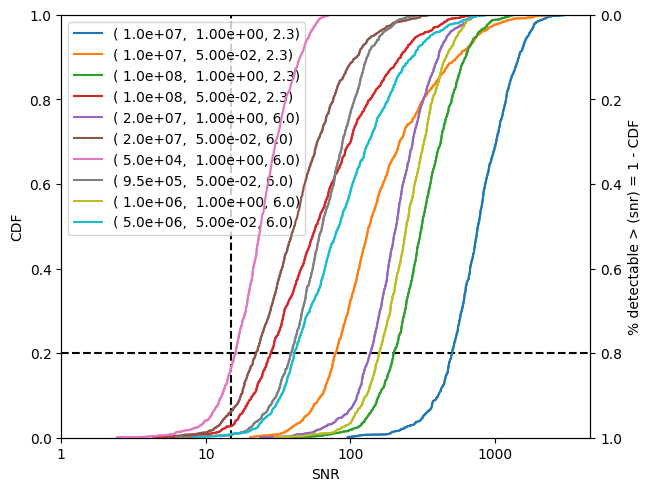

In [10]:
from astropy.cosmology import Planck15
from astropy import units as u

draws = 1024
snr_lim = 15.0
requirement = 0.8

plt.close()
fig, ax = plt.subplots(layout='constrained')
ax.axvline(np.log10(snr_lim), color="k", ls="--")
ax.axhline(1 - 0.8, color="k", ls="--")
ax2 = ax.twinx()

injs = [(1e7, 0.99999, 2.3), (1e7, 0.05, 2.3), (1e8, 0.99999, 2.3), (1e8, 0.05, 2.3), (2e7, 0.99999, 6.0), (2e7, 0.05, 6.0), (5e4, 0.99999, 6.0), (9.5e5, 0.05, 6.0), (1e6, 0.99999, 6.0), (5e6, 0.05, 6.0)]
for i, (M, q, z) in enumerate(injs):
    new_systems = transform_fn_mbh.both_transforms(priors_mbh.rvs(size=draws))

    m1 = M / (1 + q)
    m2 = M * q / (1 + q)
    new_systems[:, 0] = m1
    new_systems[:, 1] = m2
    dL = Planck15.luminosity_distance(z).to(u.m).value
    print(f"z: {z}, dL: {Planck15.luminosity_distance(z).to(u.Gpc)}")
    new_systems[:, 4] = dL
    
    snrs_out = np.zeros(draws)
    for j in range(draws):
        snrs_out[j] = calculators["bbh"].get_snr(*new_systems[j], freqs=np.logspace(-4, 0, 1024))
    
    log10_snrs_out = np.log10(snrs_out.copy())

    cdf = np.arange(1, log10_snrs_out.shape[0] + 1) / log10_snrs_out.shape[0]
    det_frac = 1 - cdf
    x = np.sort(snrs_out)
        
    ax.plot(np.log10(x), cdf, color=f"C{i}", label=f"({M: .01e}, {q: .02e}, {z})")
    ax2.plot(np.log10(x), det_frac, color=f"C{i}", label=f"({M: .01e}, {q: .02e}, {z})")
    
ax2.set_ylim(1.0, 0.0)
ax.set_ylim(0.0, 1.0)
ax2.set_ylabel('% detectable > (snr) = 1 - CDF')
ax.set_xlabel("SNR")
ax.set_xticks(np.log10([1, 10, 100, 1000]))
ax.set_xticklabels([1, 10, 100, 1000])
ax.set_ylabel("CDF")
ax.legend()
fig.savefig("mbh_fom_cdf.png")

### GBs

89.79315930405302


Text(0, 0.5, 'Char strain')

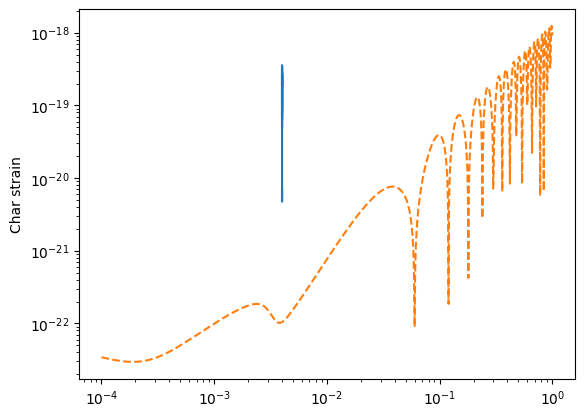

In [11]:
amp = 1e-22
f0 = 4e-3
fdot = 1e-18
fddot = 0.0
phi0 = 0.5
inc = 0.2
psi = 0.6
lam = 0.9
beta = -0.2
    
gb_injection_params = np.array([amp, f0, fdot, fddot, phi0, inc, psi, lam, beta])

print(calculators["gb"].get_snr(*gb_injection_params))
Sn = get_sensitivity(fn, model=scirdv1, sens_fn=A1TDISens, **psd_kwargs)
plt.loglog(calculators["gb"].f_arr, calculators["gb"].f_arr * np.abs(calculators["gb"].last_output[0]), c=f"C0")
df = get_df(Tobs, dt)
plt.loglog(fn, np.sqrt(fn) * Sn ** (1/2), c=f"C1", ls="--")
plt.ylabel("Char strain")

In [12]:
scaled_inj_params, cov = calculators["gb"].get_cov(
    *gb_injection_params,
    precision=True,
    more_accurate=False,
    eps=1e-11,
    deriv_inds=None,
)

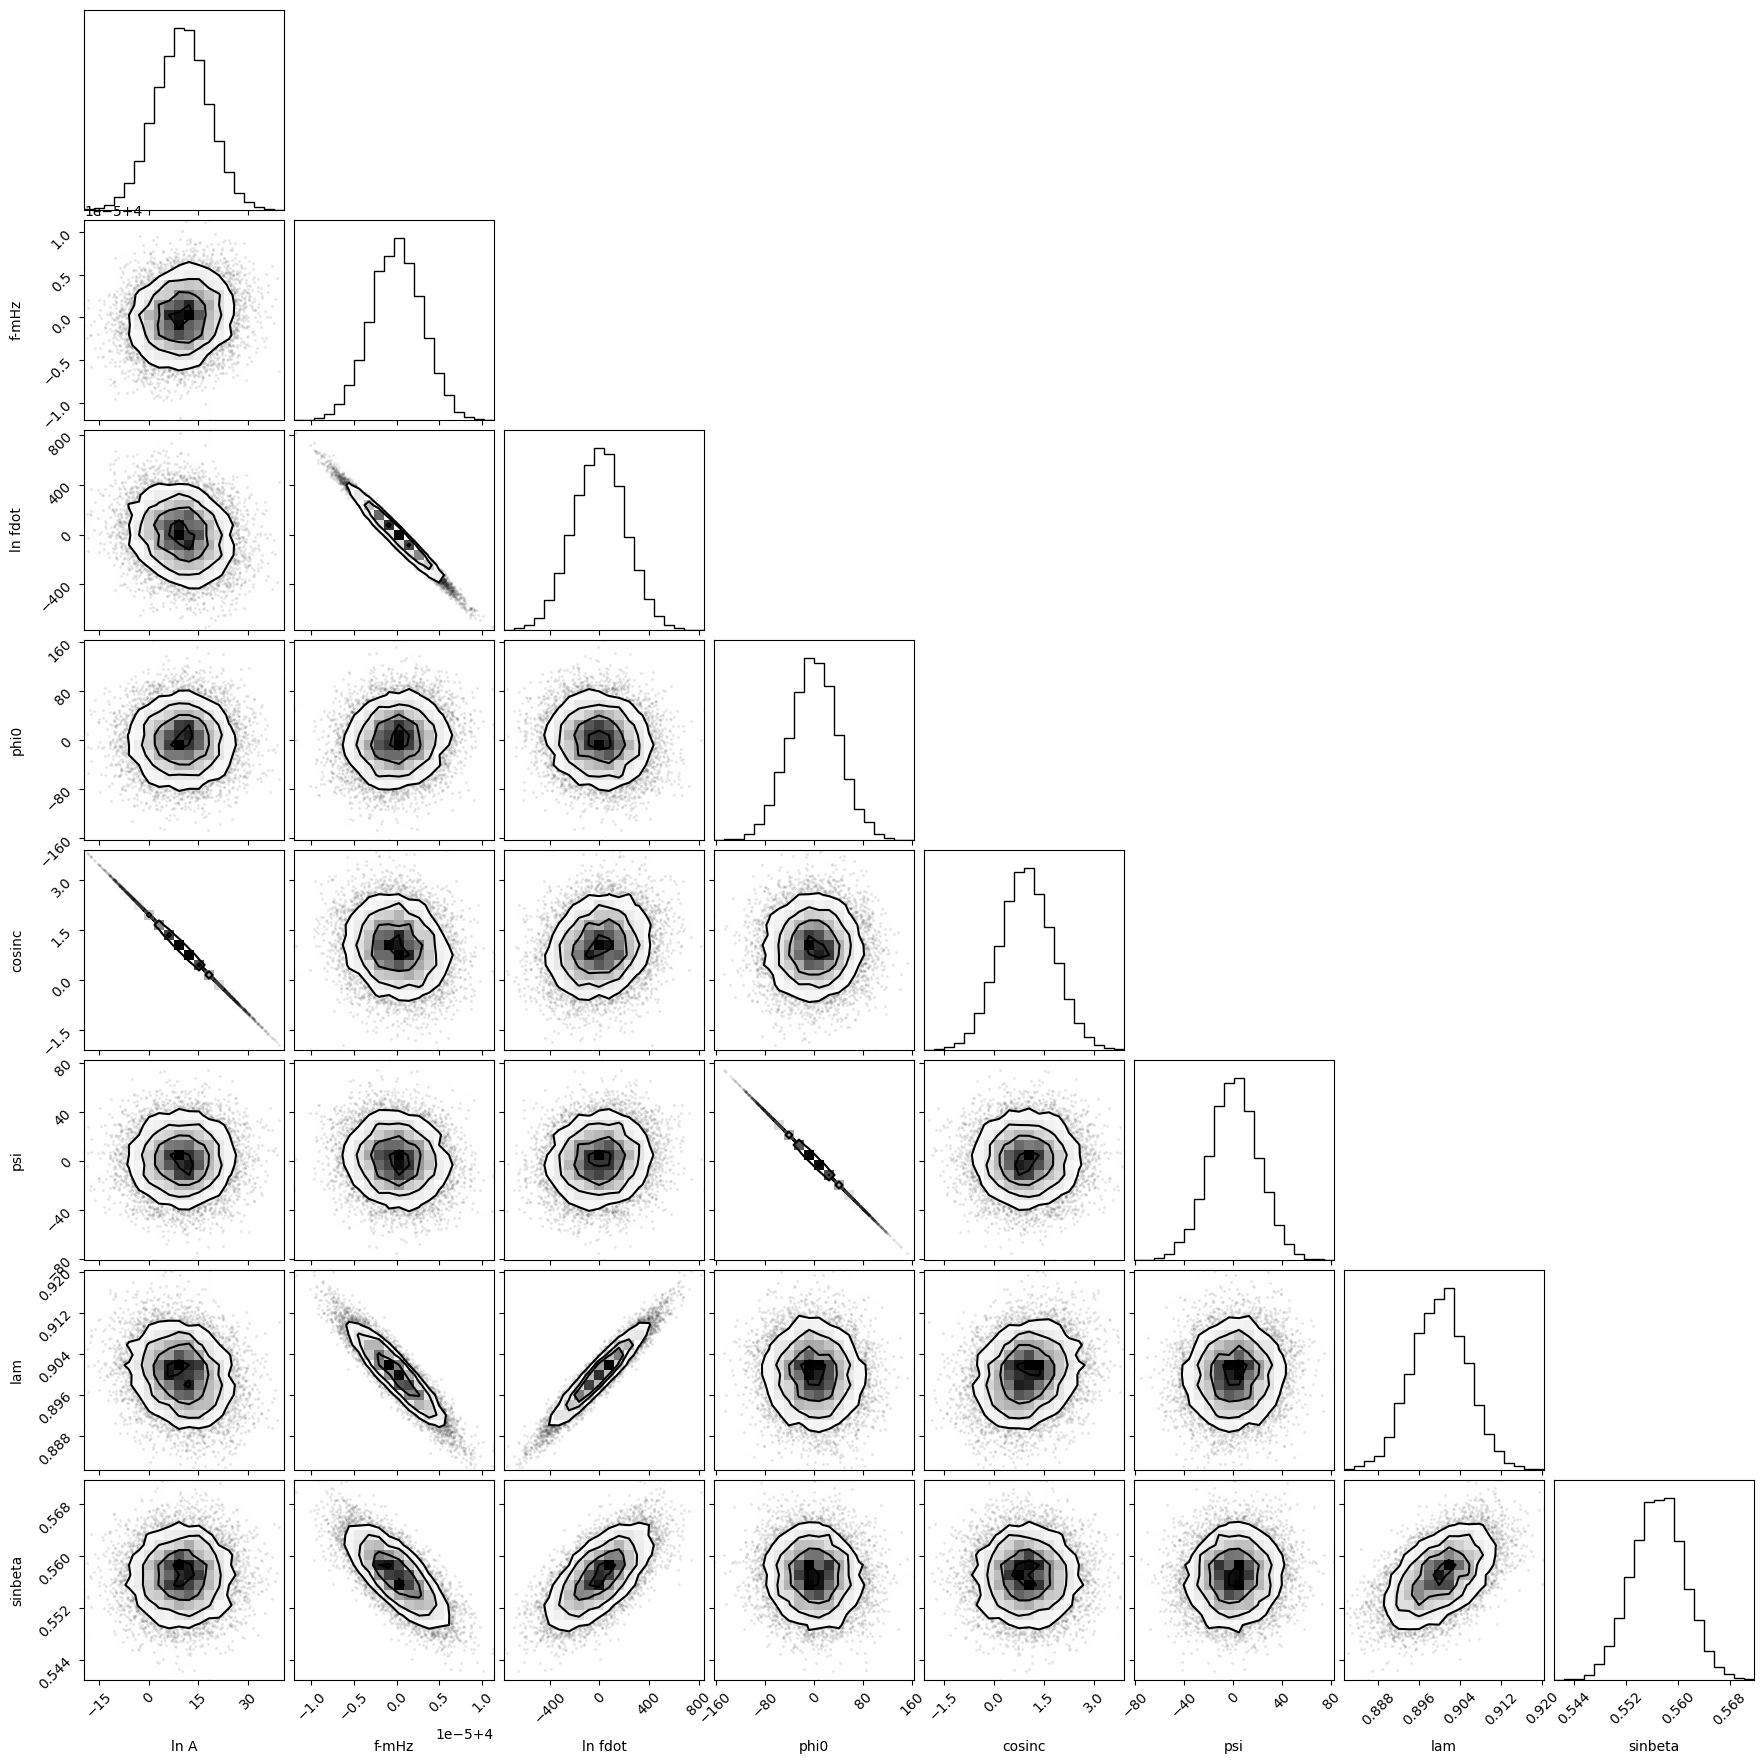

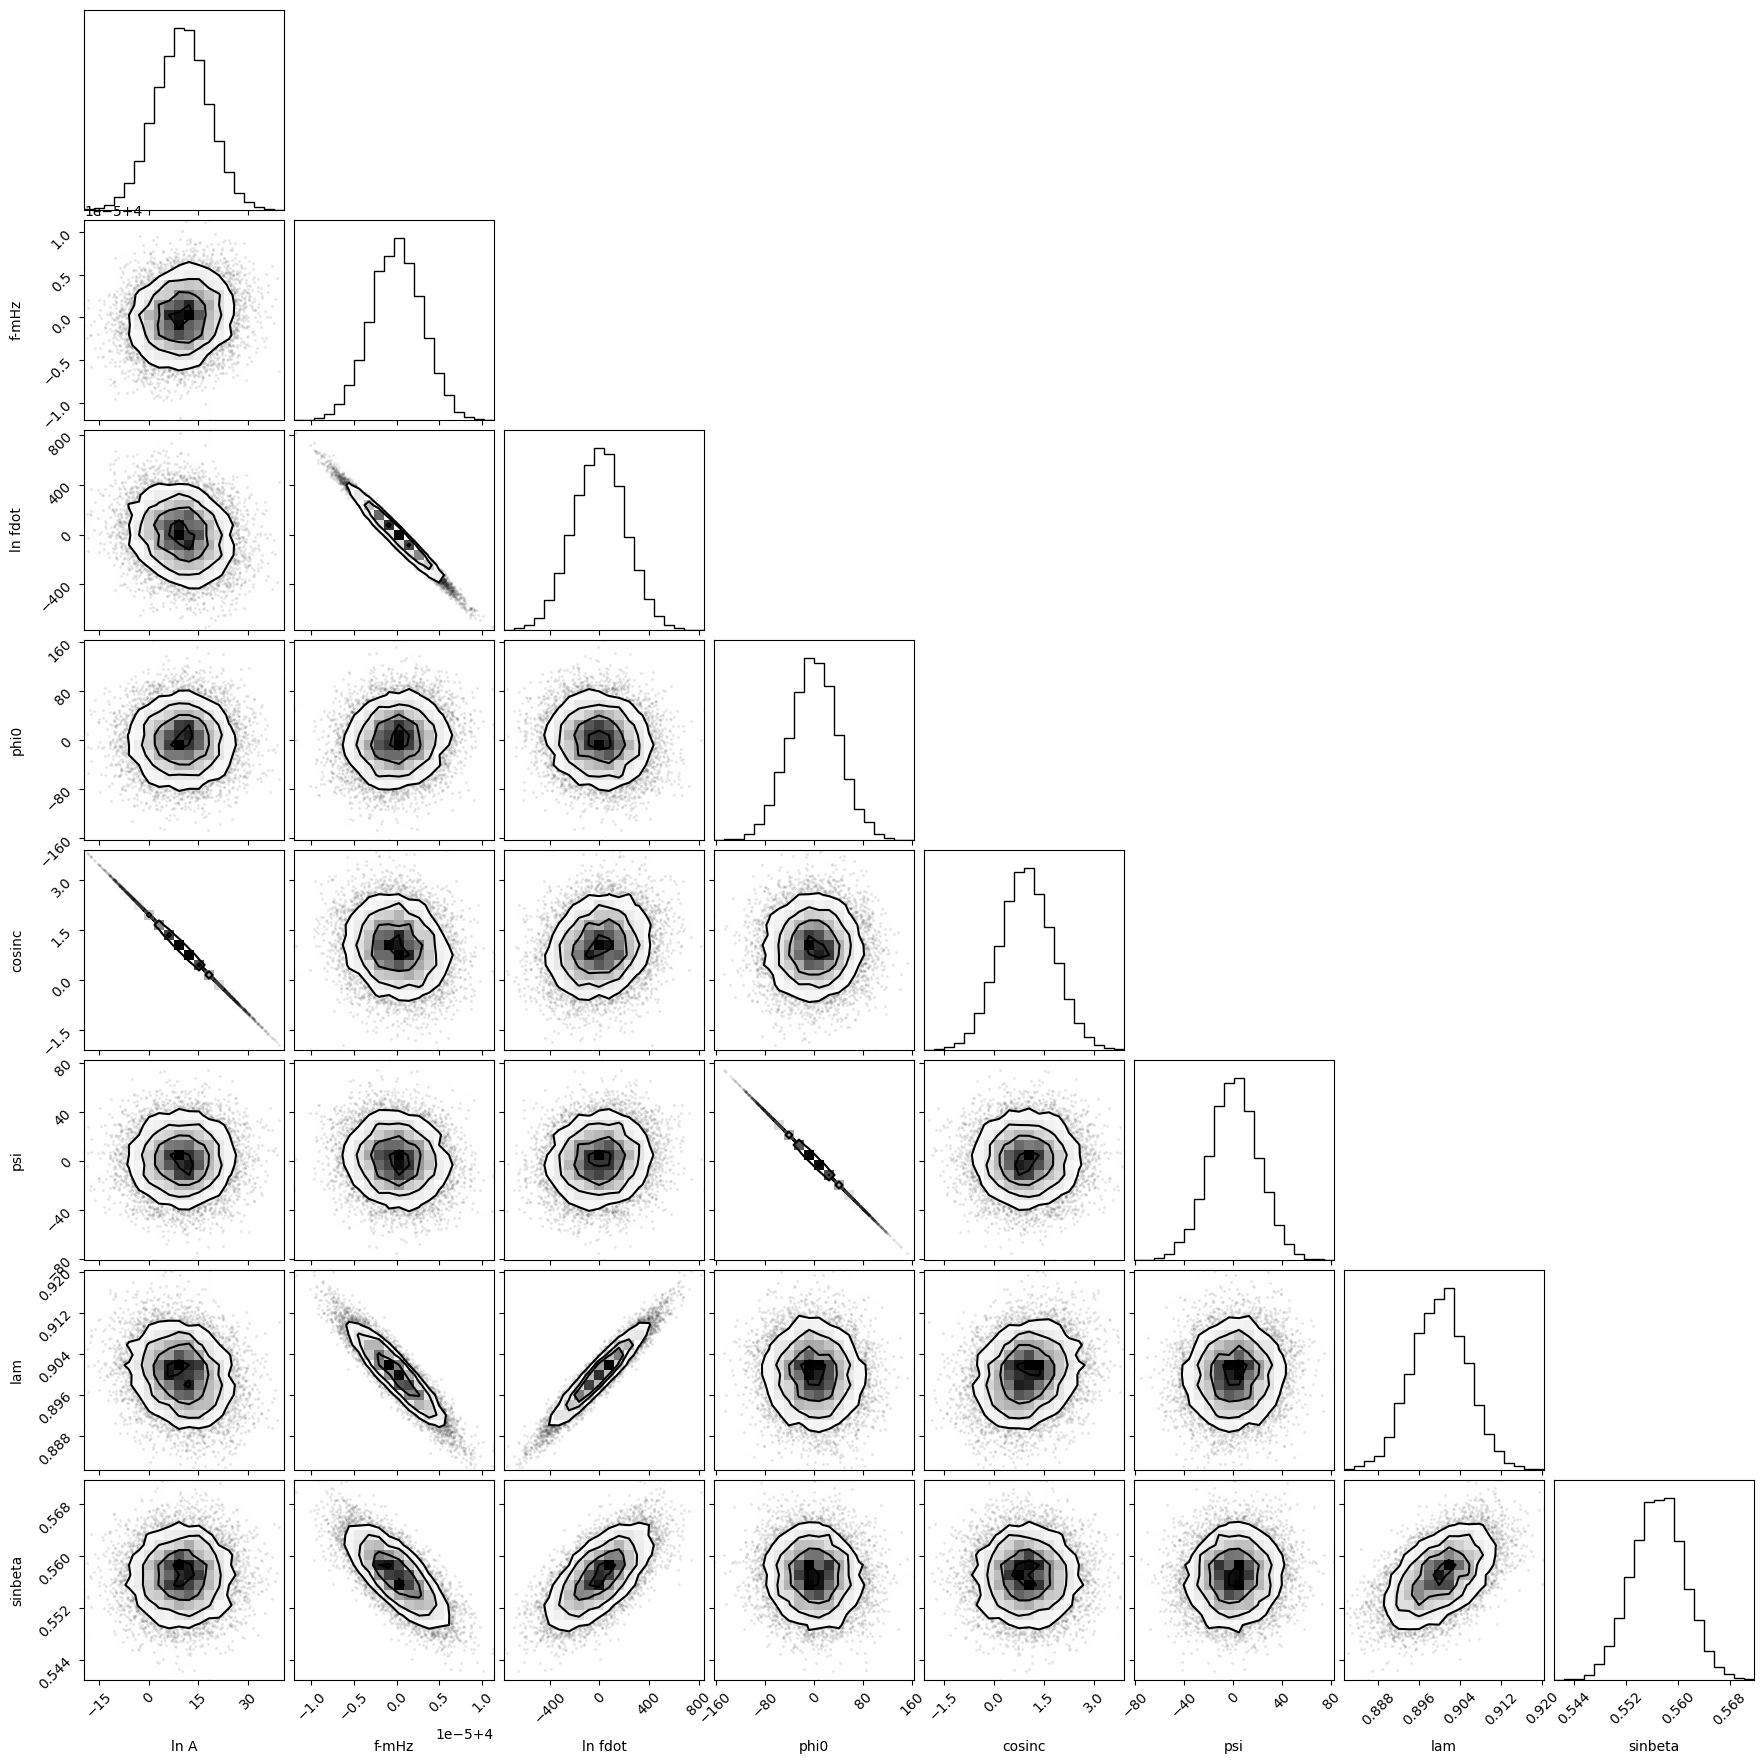

In [13]:
labels=["ln A", "f-mHz", "ln fdot", "phi0", "cosinc", "psi", "lam", "sinbeta"]
plot_covariance_corner(scaled_inj_params, cov, labels=labels, nsamp=10000)

#### VGBs Specifically

In [14]:
vgbs = pd.read_csv("vgbs.txt")

b'HPLib' 13.712579391376588
b'ZTFJ2320' 0.14804027866503625
b'SDSSJ0923' 1.9129395589009728
b'AMCVn' 20.853039727004067
b'CX1751' 1.6116621286029973
b'ZTFJ2029' 1.2169242929855304
b'SDSSJ0935' 13.238809608215753
b'ZTFJ1539' 39.99112136495842
b'SDSSJ2322' 6.5020859503079045
b'4U1820-30' 2.659593185646602
b'HMCnc' 68.6903588176616
b'CRBoo' 6.428042548240194
b'PTFJ0533' 1.9359404759328975
b'HD265435' 1.209371056329586
b'CDm30' 1.9066660880200494
b'ZTFJ0640' 0.21124386647196386
b'ZTFJ1749' 1.1014363724208696
b'SMSSJ0338' 2.184338313244035
b'SDSSJ1630' 1.643199255475971
b'ZTFJ2055' 0.2526214792083201
b'ZTFJ1901' 0.7778239233823205
b'ZTFJ1946' 0.3511686739894931
b'ESCet' 30.323745867242444
b'SDSSJ1337' 2.177444554702719
b'ZTFJ2130' 0.8095498301536229
b'V407Vul' 46.59239422333644
b'ZTFJ2243' 36.0948909855413
b'SDSSJ0634' 7.32645689889987
b'ZTFJ0722' 2.473178115092231
b'PTF1919' 1.129270916434868
b'V803Cen' 8.175355163773387
b'SDSSJ1351' 4.579730822994277
b'SDSSJ1235' 1.8790155607566321
b'ZTFJ

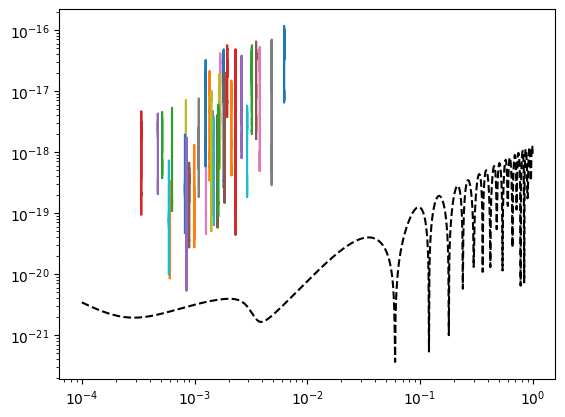

In [15]:
Sn = get_sensitivity(fn, model=scirdv1, sens_fn=A1TDISens, **psd_kwargs)
df = get_df(Tobs, dt)
plt.loglog(fn, Sn ** (1/2), c=f"k", ls="--")
for j in range(len(vgbs)):
    vgb = vgbs.iloc[j]
    params_in = np.array([
        vgb["Amplitude"],
        vgb["Frequency"],
        vgb["FrequencyDerivative"],
        0.0,
        vgb["InitialPhase"],
        vgb["Inclination"],
        vgb["Polarization"],
        vgb["EclipticLongitude"],
        vgb["EclipticLatitude"]
    ])
    print(vgb["Name"], calculators["gb"].get_snr(*params_in, tdi2=False))
    plt.loglog(calculators["gb"].f_arr, np.abs(calculators["gb"].last_output[0]), c=f"C{j}")

Starting b'HPLib'.


/Users/mlkatz1/anaconda3/envs/nasa_fom_env/lib/python3.12/site-packages/lisatools/detector.py:633: RuntimeWarning: divide by zero encountered in divide
  Sa_a = Sa_a_in * (1.0 + (0.4e-3 / frq) ** 2) * (1.0 + (frq / 8e-3) ** 4)
/Users/mlkatz1/anaconda3/envs/nasa_fom_env/lib/python3.12/site-packages/lisatools/detector.py:635: RuntimeWarning: divide by zero encountered in power
  Sa_d = Sa_a * (2.0 * np.pi * frq) ** (-4.0)
/Users/mlkatz1/anaconda3/envs/nasa_fom_env/lib/python3.12/site-packages/lisatools/detector.py:637: RuntimeWarning: invalid value encountered in multiply
  Sa_nu = Sa_d * (2.0 * np.pi * frq / C_SI) ** 2
/Users/mlkatz1/anaconda3/envs/nasa_fom_env/lib/python3.12/site-packages/lisatools/detector.py:642: RuntimeWarning: divide by zero encountered in divide
  Soms_d = Soms_d_in * (1.0 + (2.0e-3 / f) ** 4)
/Users/mlkatz1/anaconda3/envs/nasa_fom_env/lib/python3.12/site-packages/lisatools/detector.py:644: RuntimeWarning: invalid value encountered in multiply
  Soms_nu = Soms_d *

Copying old file to backup so this can run. PLEASE BE CAREFUL WITH FILES if they exist already.




00%|███████████████████████████████████████| 4000/4000 [01:51<00:00, 36.01it/s]

b'HPLib':
 (Injected val: 1.5722709617019649e-22), Mean amp: 1.8348219261507876e-22, diff from inj: 2.625509644488227e-23, percent diff from inj: 0.16698836959032454,
 std around mean: 3.734437949862838e-23, perc error: 0.20353135618436782


Finished b'HPLib'.


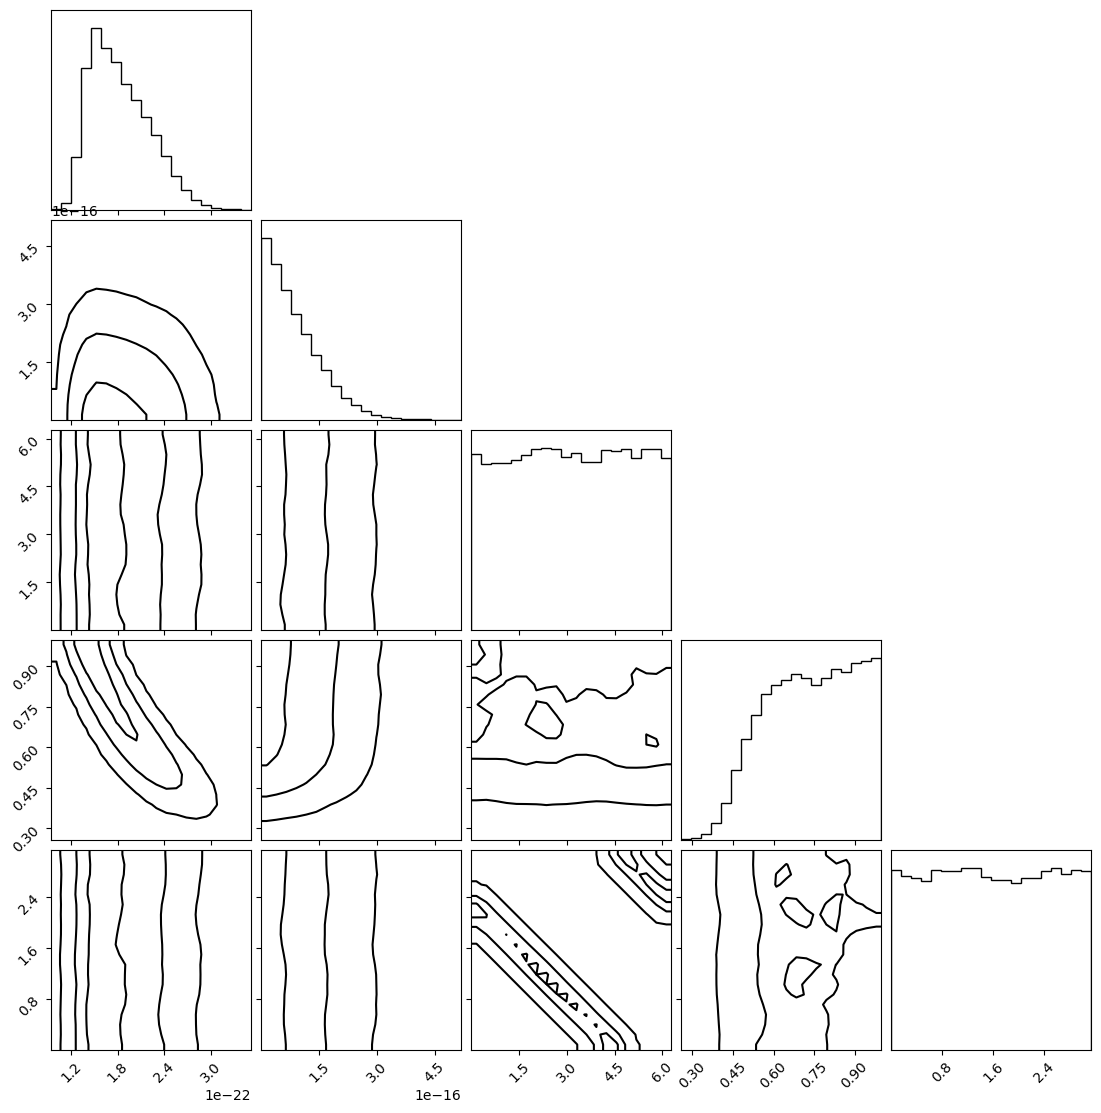

In [16]:

vgbs = pd.read_csv("vgbs.txt")

keep = [
    "b'AMCVn'",
    "b'SDSSJ1908'",
    "b'HPLib'",
    "b'V803Cen'",
    "b'J0526+5934'",
    "b'HMCnc'",
]

inds_keep = []
for i in range(len(vgbs)):
    vgb = vgbs.iloc[i]

    if vgb["Name"] in keep:
        inds_keep.append(i)
inds_keep = np.asarray(inds_keep)
vgbs_keep = vgbs.iloc[inds_keep]
# adjust in iloc below if you do not want to run all of them
run_posterior_estimate_vgbs(vgbs.iloc[:], nsteps=4000, burn=5000, filename_base="vgb_sample_storage")

# parameters assume you are puting in a VGB and fixing frequency and sky location. 

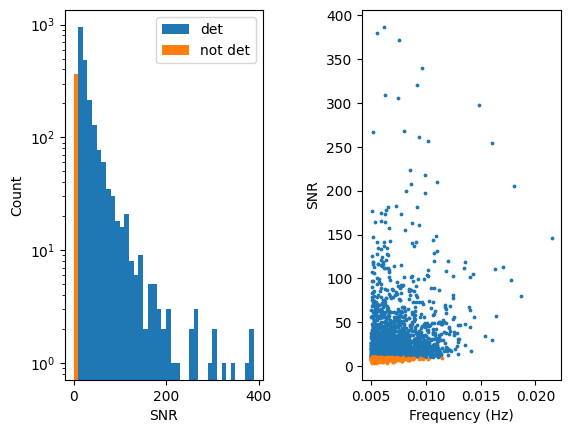

In [17]:
params = np.load("ldc2a_inj.npy")
params = params[params["Frequency"] < 0.035]
freqs_out = []
snrs_out = []
for j in range(len(params)):
    gb_par = params[j]
    params_in = np.array([
        gb_par["Amplitude"],
        gb_par["Frequency"],
        gb_par["FrequencyDerivative"],
        0.0,
        gb_par["InitialPhase"],
        gb_par["Inclination"],
        gb_par["Polarization"],
        gb_par["EclipticLongitude"],
        gb_par["EclipticLatitude"]
    ])
    
    snrs_out.append(calculators["gb"].get_snr(*params_in, tdi2=False))
    freqs_out.append(gb_par["Frequency"])
    
    # plt.loglog(calculators["gb"].f_arr, np.abs(calculators["gb"].last_output[0]), c=f"C{j}")

snrs_out = np.asarray(snrs_out)
freqs_out = np.asarray(freqs_out)

bins = np.arange(0, 400, 10)
fig, (ax1, ax2) = plt.subplots(1, 2)
plt.subplots_adjust(wspace=0.5)
ax1.hist(snrs_out[snrs_out > 10.0], bins=bins, log=True, density=False, color="C0", label="det")
ax1.hist(snrs_out[snrs_out < 10.0], bins=bins, log=True, density=False, color="C1", label="not det")
ax2.scatter(freqs_out[snrs_out > 10.0], snrs_out[snrs_out > 10.0], color="C0", s=3)
ax2.scatter(freqs_out[snrs_out < 10.0], snrs_out[snrs_out < 10.0], color="C1", s=3)
ax1.set_ylabel("Count")
ax1.set_xlabel("SNR")
ax2.set_xlabel("Frequency (Hz)")
ax2.set_ylabel("SNR")
ax1.legend(loc="upper right")

fig.savefig("above_5mHz_snr_counts_fom.png", dpi=150)

### EMRIs

/Users/mlkatz1/anaconda3/envs/nasa_fom_env/lib/python3.12/site-packages/lisatools/detector.py:633: RuntimeWarning: divide by zero encountered in divide
  Sa_a = Sa_a_in * (1.0 + (0.4e-3 / frq) ** 2) * (1.0 + (frq / 8e-3) ** 4)
/Users/mlkatz1/anaconda3/envs/nasa_fom_env/lib/python3.12/site-packages/lisatools/detector.py:635: RuntimeWarning: divide by zero encountered in power
  Sa_d = Sa_a * (2.0 * np.pi * frq) ** (-4.0)
/Users/mlkatz1/anaconda3/envs/nasa_fom_env/lib/python3.12/site-packages/lisatools/detector.py:637: RuntimeWarning: invalid value encountered in multiply
  Sa_nu = Sa_d * (2.0 * np.pi * frq / C_SI) ** 2
/Users/mlkatz1/anaconda3/envs/nasa_fom_env/lib/python3.12/site-packages/lisatools/detector.py:642: RuntimeWarning: divide by zero encountered in divide
  Soms_d = Soms_d_in * (1.0 + (2.0e-3 / f) ** 4)
/Users/mlkatz1/anaconda3/envs/nasa_fom_env/lib/python3.12/site-packages/lisatools/detector.py:644: RuntimeWarning: invalid value encountered in multiply
  Soms_nu = Soms_d *

65.85047061377965


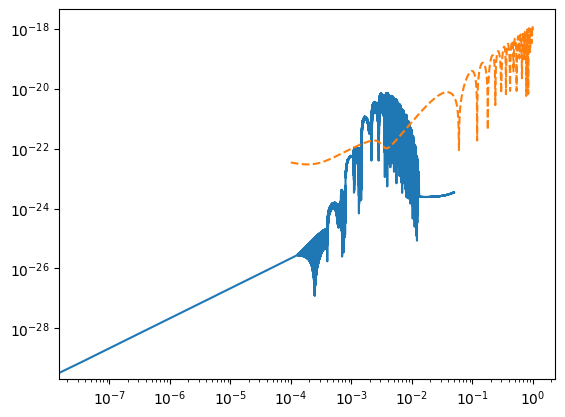

In [18]:
M = 1e6
mu = 1e1
a = 0.2
p0 = 7.0  # will integrate backwards (see below for getting separatrix)
e0 = 0.2
x0 = 1.0
dist = 3.0
phiS = 0.4423
qS = 0.523023
qK = 0.8923123
phiK = 0.1221209312
Phi_phi0 = 0.1231232
Phi_theta0 = 4.234903824
Phi_r0 = 3.230923

emri_injection_params = np.array(
    [M, mu, a, p0, e0, x0, dist, qS, phiS, qK, phiK, Phi_phi0, Phi_theta0, Phi_r0]
)

print(calculators["emri"].get_snr(*emri_injection_params))
Sn = get_sensitivity(fn, model=scirdv1, sens_fn=A1TDISens, **psd_kwargs)
emri_freqs = np.fft.rfftfreq(calculators["emri"].last_output[0].shape[0], calculators["emri"].aet_template_gen.dt)
plt.loglog(emri_freqs, emri_freqs * np.abs(np.fft.rfft(calculators["emri"].last_output[0])) * calculators["emri"].aet_template_gen.dt, c=f"C0")
plt.loglog(fn, np.sqrt(fn) * (Sn) ** (1/2), c=f"C1", ls="--")


In [19]:
from eryn.prior import uniform_dist, ProbDistContainer
from eryn.utils import TransformContainer
from few.utils.geodesic import get_separatrix
from few.trajectory.ode import KerrEccEqFlux

# priors
priors_emri = ProbDistContainer({
    0: uniform_dist(np.log(1e5), np.log(1e6)),
    1: uniform_dist(10.0, 50.0),
    2: uniform_dist(0.0001, +0.95),
    3: uniform_dist(6.5, 9.0),  # this will be ignored
    4: uniform_dist(0.01, 0.3),
    5: uniform_dist(-1.0, 1.0), # this will be ignored up to picking prograde / retrograde
    6: uniform_dist(0.01, 10.0),
    7: uniform_dist(-0.99, 0.99),
    8: uniform_dist(0.0, 2 * np.pi),
    9: uniform_dist(-0.99, 0.99),
    10: uniform_dist(0.0, 2 * np.pi),
    11: uniform_dist(0.0, 2 * np.pi),
    12: uniform_dist(0.0, 2 * np.pi),
    13: uniform_dist(0.0, 2 * np.pi), 
})

 # for transforms
fill_dict_emri = None

# transforms from pe to waveform generation
parameter_transforms_emri = {
    0: np.exp,
    7: np.arccos,
    9: np.arccos,
}

transform_fn_emri = TransformContainer(
    parameter_transforms=parameter_transforms_emri,
    fill_dict=fill_dict_emri,
)



In [ ]:

draws = 32
snr_lim = 25.0
requirement = 0.8

# TODO: change to source frame associated values
masses = [(1e6, 10.0)]  # , (3e5, 10.0)]  # (1e7, 10.0), (1e6, 10.0), (1e5, 10.0), (5e5, 10.0), (5e6, 10.0), (3e5, 10.0)]
dL = 1.0
fig, ax = plt.subplots(layout='constrained')

Delta_p = KerrEccEqFlux().separatrix_buffer_dist
prograde = True
xI = 1.0 if prograde else -1.0
for i, (M, mu) in enumerate(masses):
    new_systems = transform_fn_emri.both_transforms(priors_emri.rvs(size=draws))

    new_systems[:, 0] = M
    new_systems[:, 1] = mu
    # dL = Planck15.luminosity_distance(z).to(u.Gpc).value
    # print(f"z: {z}, dL: {Planck15.luminosity_distance(z).to(u.Gpc)}")
    
    new_systems[:, 6] = dL

    new_systems[:, 5] = xI

    a_all = new_systems[:, 2]
    e_all = new_systems[:, 4]

    p_sep = np.asarray([get_separatrix(a, e, xI) for a, e, in zip(a_all, e_all)])
    p0_all = p_sep + Delta_p  # the separatrix at the trajectory end-point.

    new_systems[:, 3] = p0_all

    snrs_out = np.zeros(draws)
    for j in range(draws):
        snrs_out[j] = calculators["emri"].get_snr(*new_systems[j])
        print(i, j, snrs_out[j])
    
    plt.close()
    ax.axvline(np.log10(snr_lim), color="k", ls="--")
    ax.text(np.log10(snr_lim), 1.02, "SNR=25", ha="center")
    
    ax.axvline(np.log10(10.0), color="k", ls="--")
    ax.text(np.log10(10.0), 1.02, "SNR=10", ha="center")
    
    ax.axhline(1 - 0.8, color="k", ls="--")
    ax2 = ax.twinx() 
    lss = ["solid", "dashed"]
    for jj, dL_tmp in enumerate([1.0]):
        snrs_here = snrs_out.copy() * (dL / dL_tmp)
        log10_snrs_out = np.log10(snrs_here)
    
        cdf = np.arange(1, log10_snrs_out.shape[0] + 1) / log10_snrs_out.shape[0]
        det_frac = (1 - cdf) * 100
        x = np.sort(snrs_here)
            
        ax.plot(np.log10(x), cdf, color=f"C{i}", label=f"({M: .0e}, {mu: .0e}, {dL_tmp})")
        ax2.plot(np.log10(x), det_frac, color=f"C{i}", label=f"({M: .0e}, {mu: .0e}, {dL_tmp})")
            
    ax2.set_ylim(100.0, 0.0)
    ax.set_ylim(0.0, 1.0)
    ax2.set_ylabel('% detectable > (snr) = 1 - CDF')
    ax.set_xlabel("SNR")
    ax.set_xticks(np.log10([1, 10, 100, 1000]))
    ax.set_xticklabels([1, 10, 100, 1000])
    ax.set_ylabel("CDF")
    ax.legend()
fig.savefig(f"emris_detectability_fom.png")
       

/Users/mlkatz1/anaconda3/envs/nasa_fom_env/lib/python3.12/site-packages/lisatools/detector.py:633: RuntimeWarning: divide by zero encountered in divide
  Sa_a = Sa_a_in * (1.0 + (0.4e-3 / frq) ** 2) * (1.0 + (frq / 8e-3) ** 4)
/Users/mlkatz1/anaconda3/envs/nasa_fom_env/lib/python3.12/site-packages/lisatools/detector.py:635: RuntimeWarning: divide by zero encountered in power
  Sa_d = Sa_a * (2.0 * np.pi * frq) ** (-4.0)
/Users/mlkatz1/anaconda3/envs/nasa_fom_env/lib/python3.12/site-packages/lisatools/detector.py:637: RuntimeWarning: invalid value encountered in multiply
  Sa_nu = Sa_d * (2.0 * np.pi * frq / C_SI) ** 2
/Users/mlkatz1/anaconda3/envs/nasa_fom_env/lib/python3.12/site-packages/lisatools/detector.py:642: RuntimeWarning: divide by zero encountered in divide
  Soms_d = Soms_d_in * (1.0 + (2.0e-3 / f) ** 4)
/Users/mlkatz1/anaconda3/envs/nasa_fom_env/lib/python3.12/site-packages/lisatools/detector.py:644: RuntimeWarning: invalid value encountered in multiply
  Soms_nu = Soms_d *

0 0 283.54426871420293
0 1 138.52287208945847
0 2 233.11370912516102
